In [3]:
%reset
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
import numpy as np
import pandas as pd
from scipy import signal
import statistics as stats
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from scipy import stats

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
def weighted_average(distribution, weights):
    return round(sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights),2)

def import_csv(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                #0-Time 1-Source 2-bdp 3-arr_in_bdp  4-AverageRttValue 5-pktsize 6-ratio/0.2 
                #7-CoV--CoVs.size () 8-occ_in_bdp_per_source 9-psi_mm1_per_source 
                #10-aggreg_occ_in_bdp 11-aggreg_psi_mm1
                columns = [row[0], row[1], row[2], row[3], row[4], 
                           row[5], row[6], row[7], row[8], row[9], row[10], row[11], row[12], row[13]]
                data.append(columns)

    return data

In [5]:
tcp_ccas = ([ 'TcpNewReno', 'TcpCubic', 'TcpVegas', 'TcpBbrV2',
             'TcpModNewReno'])
BDP = 173
buffer_sizes = ([0, 10, 43, 87, 130, 1*BDP, 2*BDP, 3*BDP, 4*BDP, 5*BDP, 6*BDP, 7*BDP, 8*BDP, 9*BDP, 10*BDP]) 
print(tcp_ccas)
print(buffer_sizes)

['TcpNewReno', 'TcpCubic', 'TcpVegas', 'TcpBbrV2', 'TcpModNewReno']
[0, 10, 43, 87, 130, 173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730]


In [6]:
data_in = {}
buffer_effect = {}
for algorithm in tcp_ccas:
                #0-Time 1-Source 2-bdp_pkts 3-arr_Mbps 4-aggreg_ar_Mbps
                #5-AverageRttValue 6-pktsize 7-mupsi 
                #8-aggreg_mupsi 9-occ_bdp_per_source 10-mupsi_mm1_per_source 
                #11-aggreg_occ_bdp 12-aggreg_mupsi_mm1 13-measured_btlBW_Mbps
    buffer_effect[algorithm] ={'buffer': list(), 'mean_arrival_rate': list(), 'mean_aggreg_arrival_rate': list(),
                               'mean_avRTT': list(),
                                'mean_mu_psi': list(), 'mean_occ_in_bdp_per_source': list(), 
                                'mean_psi_mm1_per_source': list(), 'mean_aggreg_occ_in_bdp': list(), 
                                'mean_aggreg_psi_mm1': list(), 'response_time': list()}
    
b_bdp = 0    
for b in buffer_sizes:
    data_in[b_bdp] = {}
    for algorithm in tcp_ccas:
        data_in[b_bdp][algorithm]={'time': list(), 'arrival_rate': list(), 'aggreg_arrival_rate': list(),
                                   'avRTT': list(), 'mu_psi': list(),
                                'occ_in_bdp_per_source': list(), 'mu_psi_mm1_per_source': list(),
                                'aggreg_occ_in_bdp': list(), 'aggreg_mu_psi_mm1': list(),
                                'response_time': list()}
        files = []
        files.append("sim4_tikhonov/5-flows/10Mbps-100ms/" + str(b) 
              + "p-btlqueue/" + algorithm + "-5-flows-10Mbps-100ms-" + str(b)
              + "p-InFlight.dat")
        
        for file_name in files:
            raw_data = import_csv(file_name);
            for row in raw_data:
                data_in[b_bdp][algorithm]['time'].append({row[0]})
                data_in[b_bdp][algorithm]['arrival_rate'].append({row[3]})
                data_in[b_bdp][algorithm]['aggreg_arrival_rate'].append({row[4]})
                data_in[b_bdp][algorithm]['avRTT'].append({row[5]})
                data_in[b_bdp][algorithm]['mu_psi'].append({row[7]})
                data_in[b_bdp][algorithm]['occ_in_bdp_per_source'].append({row[9]})
                data_in[b_bdp][algorithm]['mu_psi_mm1_per_source'].append({row[10]})
                data_in[b_bdp][algorithm]['aggreg_occ_in_bdp'].append({row[11]})
                data_in[b_bdp][algorithm]['aggreg_mu_psi_mm1'].append({row[12]})
                

            buffer_effect[algorithm]['buffer'].append(b/173)
            buffer_effect[algorithm]['mean_arrival_rate'].\
                append(pd.DataFrame(list(data_in[b_bdp][algorithm]['arrival_rate'])).\
                                     astype(float).mean())
            buffer_effect[algorithm]['mean_aggreg_arrival_rate'].\
                append(pd.DataFrame(list(data_in[b_bdp][algorithm]['aggreg_arrival_rate'])).\
                                     astype(float).mean())
            buffer_effect[algorithm]['mean_avRTT'].\
                append(pd.DataFrame(list(data_in[b_bdp][algorithm]['avRTT'])).\
                                     astype(float).mean())
            buffer_effect[algorithm]['mean_mu_psi'].\
                append(pd.DataFrame(data_in[b_bdp][algorithm]['mu_psi']).\
                                     astype(float).mean())
            buffer_effect[algorithm]['mean_occ_in_bdp_per_source'].\
                append(pd.DataFrame(list(data_in[b_bdp][algorithm]['occ_in_bdp_per_source'])).\
                                     astype(float).mean())
            buffer_effect[algorithm]['mean_aggreg_occ_in_bdp'].\
                append(pd.DataFrame(list(data_in[b_bdp][algorithm]['aggreg_occ_in_bdp'])).\
                                     astype(float).mean())
            mean_arrival_rate = 1e6*(1.0/8.0)*(1.0/1448)*(1.0/166.0)*pd.DataFrame( \
                                    list(data_in[b_bdp][algorithm]['aggreg_arrival_rate'])).\
                                    astype(float).mean()
            mean_occ = pd.DataFrame(list(data_in[b_bdp][algorithm]['aggreg_occ_in_bdp'])).\
                                    astype(float).mean()
            response_time = mean_occ/mean_arrival_rate
            buffer_effect[algorithm]['response_time'].append(response_time)
    
    b_bdp += 1


In [7]:
print(1e6)

1000000.0


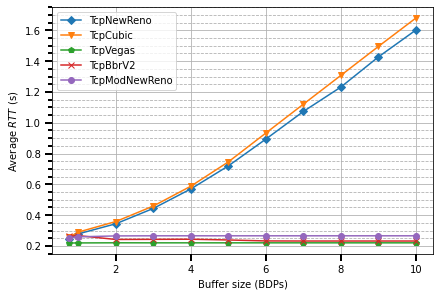

In [9]:
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.plot(buffer_effect[tcp_ccas[0]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[0]]['mean_avRTT']).
         rolling(window=5, win_type=None).mean(), 'D-',
        buffer_effect[tcp_ccas[1]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[1]]['mean_avRTT']).
         rolling(window=5, win_type=None).mean(), 'v-',
        buffer_effect[tcp_ccas[2]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[2]]['mean_avRTT']).
         rolling(window=5, win_type=None).mean(), 'p-',
        buffer_effect[tcp_ccas[3]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[3]]['mean_avRTT']).
         rolling(window=5, win_type=None).mean(), 'x-',
        buffer_effect[tcp_ccas[4]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[4]]['mean_avRTT']).
         rolling(window=5, win_type=None).mean(), 'o-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Buffer size (BDPs)')
plt.ylabel(r'Average $RTT$ (s)')
#plt.xscale('log')
#x = [0.0058, 0.05, 0.1, 0.2, 0.5, 1, 2, 4, 6, 10]
#values = ['0.0', '0.05', '0.1', '0.2', '0.5', '1', '2', '4', '6', '10']
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,2)
#plt.xlim(0.0001,10)
plt.grid(True)
plt.legend([
            tcp_ccas[0], tcp_ccas[1], tcp_ccas[2], tcp_ccas[3], tcp_ccas[4]
           ])
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('avRTT_vs_buffer.png', transparent=True)

In [10]:
print(10e6*1e-6)

10.0


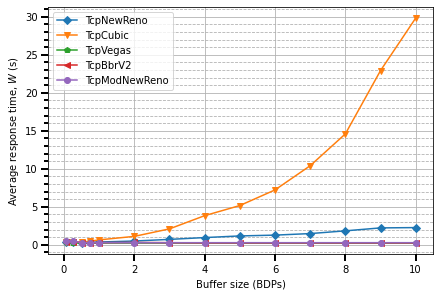

In [11]:
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.plot(buffer_effect[tcp_ccas[0]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[0]]['response_time']).
         rolling(window=2, win_type=None).mean(), 'D-',
        buffer_effect[tcp_ccas[1]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[1]]['response_time']).
         rolling(window=2, win_type=None).mean(), 'v-',
        buffer_effect[tcp_ccas[2]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[2]]['response_time']).
         rolling(window=2, win_type=None).mean(), 'p-',
        buffer_effect[tcp_ccas[3]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[3]]['response_time']).
         rolling(window=2, win_type=None).mean(), '<-',
        buffer_effect[tcp_ccas[4]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[4]]['response_time']).
         rolling(window=2, win_type=None).mean(), 'o-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Buffer size (BDPs)')
plt.ylabel(r'Average response time, $W$ (s)')
#plt.xscale('log')
#x = [0.0058, 0.05, 0.1, 0.2, 0.5, 1, 2, 4, 6, 10]
#values = ['0.0', '0.05', '0.1', '0.2', '0.5', '1', '2', '4', '6', '10']
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,5)
#plt.xlim(0.0001,10)
plt.grid(True)
plt.legend([
            tcp_ccas[0], tcp_ccas[1], tcp_ccas[2], tcp_ccas[3], tcp_ccas[4]
           ])
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('W_vs_buffer.png', transparent=True)

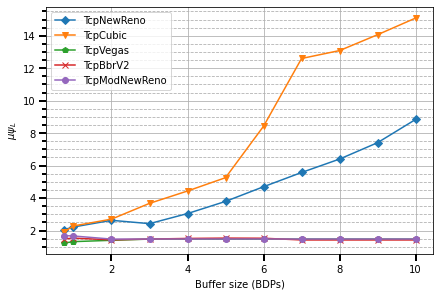

In [12]:
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.plot(
            buffer_effect[tcp_ccas[0]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[0]]['mean_mu_psi']).
                        rolling(window=5, win_type=None).mean(), 'D-',
            buffer_effect[tcp_ccas[1]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[1]]['mean_mu_psi']).
                        rolling(window=5, win_type=None).mean(), 'v-',
            buffer_effect[tcp_ccas[2]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[2]]['mean_mu_psi']).
                        rolling(window=5, win_type=None).mean(), 'p-',
            buffer_effect[tcp_ccas[3]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[3]]['mean_mu_psi']).
                        rolling(window=5, win_type=None).mean(), 'x-',
            buffer_effect[tcp_ccas[4]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[4]]['mean_mu_psi']).
                        rolling(window=5, win_type=None).mean(), 'o-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Buffer size (BDPs)')
plt.ylabel(r'$\mu \psi_L$')
#plt.xscale('log')
#x = [0.0058, 0.05, 0.1, 0.2, 0.5, 1, 2, 4, 6, 10]
#values = ['0.0', '0.05', '0.1', '0.2', '0.5', '1', '2', '4', '6', '10']
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0.5,5)
#plt.xlim(0.0001,10)
plt.grid(True)
plt.legend([
            tcp_ccas[0], tcp_ccas[1], tcp_ccas[2], tcp_ccas[3], tcp_ccas[4]
           ])
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('mupsi_vs_buffer.png', transparent=True)

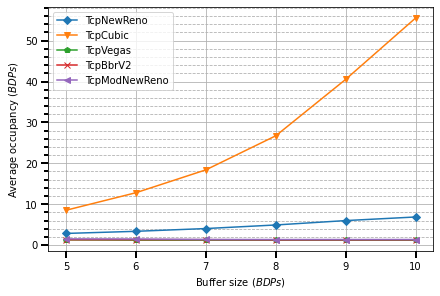

In [13]:
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.plot(
            buffer_effect[tcp_ccas[0]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[0]]['mean_aggreg_occ_in_bdp']).
                        rolling(window=10, win_type=None).mean(), 'D-',
            buffer_effect[tcp_ccas[1]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[1]]['mean_aggreg_occ_in_bdp']).
                        rolling(window=10, win_type=None).mean(), 'v-',
            buffer_effect[tcp_ccas[2]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[2]]['mean_aggreg_occ_in_bdp']).
                        rolling(window=10, win_type=None).mean(), 'p-',
            buffer_effect[tcp_ccas[3]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[3]]['mean_aggreg_occ_in_bdp']).
                        rolling(window=10, win_type=None).mean(), 'x-',
            buffer_effect[tcp_ccas[4]]['buffer'], pd.DataFrame(buffer_effect[tcp_ccas[4]]['mean_aggreg_occ_in_bdp']).
                        rolling(window=10, win_type=None).mean(), '<-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Buffer size ($BDPs$)')
plt.ylabel(r'Average occupancy ($BDPs$)')
#plt.xscale('log')
#x = [0.0058, 0.05, 0.1, 0.2, 0.5, 1, 2, 4, 6, 10]
#values = ['0.0', '0.05', '0.1', '0.2', '0.5', '1', '2', '4', '6', '10']
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,20)
#plt.xlim(0.0001,10)
plt.grid(True)
plt.legend([tcp_ccas[0], tcp_ccas[1], tcp_ccas[2], tcp_ccas[3], tcp_ccas[4]])
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('occupancy_vs_buffer.png', transparent=True)

<function matplotlib.pyplot.show(close=None, block=None)>

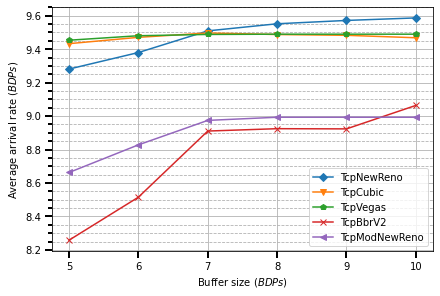

In [36]:
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.plot(
        buffer_effect[tcp_ccas[0]]['buffer'],
             pd.DataFrame(buffer_effect[tcp_ccas[0]]['mean_aggreg_arrival_rate']).
             rolling(window=10, win_type=None).mean(), 'D-',
        buffer_effect[tcp_ccas[1]]['buffer'], 
             pd.DataFrame(buffer_effect[tcp_ccas[1]]['mean_aggreg_arrival_rate']).
             rolling(window=10, win_type=None).mean(), 'v-',
        buffer_effect[tcp_ccas[2]]['buffer'], 
             pd.DataFrame(buffer_effect[tcp_ccas[2]]['mean_aggreg_arrival_rate']).
             rolling(window=10, win_type=None).mean(), 'p-',
        buffer_effect[tcp_ccas[3]]['buffer'], 
             pd.DataFrame(buffer_effect[tcp_ccas[3]]['mean_aggreg_arrival_rate']).
             rolling(window=10, win_type=None).mean(), 'x-',
        buffer_effect[tcp_ccas[4]]['buffer'], 
             pd.DataFrame(buffer_effect[tcp_ccas[4]]['mean_aggreg_arrival_rate']).
             rolling(window=10, win_type=None).mean(), '<-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Buffer size ($BDPs$)')
plt.ylabel(r'Average arrival rate ($BDPs$)')
#plt.xscale('log')
#x = [0.0058, 0.05, 0.1, 0.2, 0.5, 1, 2, 4, 6, 10]
#values = ['0.0', '0.05', '0.1', '0.2', '0.5', '1', '2', '4', '6', '10']
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0.7,1)
#plt.xlim(0.0001,10)
plt.grid(True)
plt.legend([tcp_ccas[0], tcp_ccas[1], tcp_ccas[2], tcp_ccas[3], tcp_ccas[4]], loc='lower right')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
#plt.savefig('buffer_vs_rho.png', transparent=True)

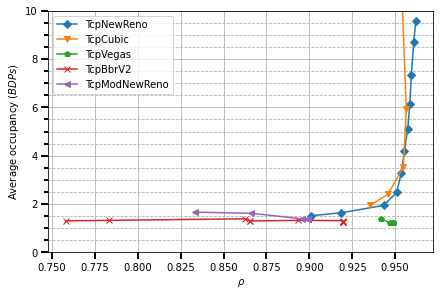

In [41]:
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.plot(
            pd.DataFrame(buffer_effect[tcp_ccas[0]]['mean_aggreg_arrival_rate']).
                        rolling(window=5, win_type=None).mean()/10, pd.DataFrame(buffer_effect[tcp_ccas[0]]['mean_aggreg_occ_in_bdp']).
                        rolling(window=5, win_type=None).mean(), 'D-',
            pd.DataFrame(buffer_effect[tcp_ccas[1]]['mean_aggreg_arrival_rate']).
                        rolling(window=5, win_type=None).mean()/10, pd.DataFrame(buffer_effect[tcp_ccas[1]]['mean_aggreg_occ_in_bdp']).
                        rolling(window=5, win_type=None).mean(), 'v-',
            pd.DataFrame(buffer_effect[tcp_ccas[2]]['mean_aggreg_arrival_rate']).
                        rolling(window=5, win_type=None).mean()/10, pd.DataFrame(buffer_effect[tcp_ccas[2]]['mean_aggreg_occ_in_bdp']).
                        rolling(window=5, win_type=None).mean(), 'p-',
            pd.DataFrame(buffer_effect[tcp_ccas[3]]['mean_aggreg_arrival_rate']).
                        rolling(window=5, win_type=None).mean()/10, pd.DataFrame(buffer_effect[tcp_ccas[3]]['mean_aggreg_occ_in_bdp']).
                        rolling(window=5, win_type=None).mean(), 'x-',
            pd.DataFrame(buffer_effect[tcp_ccas[4]]['mean_aggreg_arrival_rate']).
                        rolling(window=5, win_type=None).mean()/10, pd.DataFrame(buffer_effect[tcp_ccas[4]]['mean_aggreg_occ_in_bdp']).
                        rolling(window=5, win_type=None).mean(), '<-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'$\rho$')
plt.ylabel(r'Average occupancy ($BDPs$)')
#plt.xscale('log')
#x = [0.0058, 0.05, 0.1, 0.2, 0.5, 1, 2, 4, 6, 10]
#values = ['0.0', '0.05', '0.1', '0.2', '0.5', '1', '2', '4', '6', '10']
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(0,10)
#plt.xlim(0.0001,10)
plt.grid(True)
plt.legend([tcp_ccas[0], tcp_ccas[1], tcp_ccas[2], tcp_ccas[3], tcp_ccas[4]])
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('occupancy_vs_buffer.png', transparent=True)